In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil
import os
import cv2
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from thop import profile  # FLOPs 계산용

# 기존 모델들 import
from KD import TeacherNet, StudentNet 
from model import CircleNet, CircleDataset
from pruning import CircleNet_P

In [2]:
def load_models():
    # Basic 모델
    basic_model = CircleNet()
    basic_model.load_state_dict(torch.load('Basic_model.pth'))
    
    # Pruned 모델
    pruned_model = CircleNet_P(pruning_ratio=0.5)
    pruned_model.load_state_dict(torch.load('P_model.pth'))
    
    # KD 모델 (이전의 Quantized 모델 부분을 변경)
    student_model = StudentNet()
    student_model.load_state_dict(torch.load('KD_model.pth'))
    
    return basic_model, pruned_model, student_model

In [3]:
def calculate_flops(model, input_size=(1, 1, 416, 416)):
    """모델의 FLOPs 계산"""
    input = torch.randn(input_size)
    flops, params = profile(model, inputs=(input, ))
    return flops, params

In [4]:
def measure_model_metrics(model, test_loader, device, model_name):
    """모델의 모든 메트릭 측정"""
    print(f"\nMeasuring metrics for {model_name}...")
    model = model.to(device)
    
    # 1. 모델 크기 및 파라미터
    param_count = sum(p.numel() for p in model.parameters())
    torch.save(model.state_dict(), 'temp.pth')
    model_size = os.path.getsize('temp.pth') / (1024 * 1024)  # MB
    os.remove('temp.pth')
    
    # 2. FLOPs 계산
    try:
        flops, _ = calculate_flops(model)
    except Exception as e:
        print(f"FLOPs calculation failed: {e}")
        flops = 0
    
    # 3. 추론 성능 측정
    model.eval()
    inference_times = []
    memory_usage = []
    accuracy = []
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)
            
            # 메모리 사용량
            memory_usage.append(psutil.Process().memory_info().rss / 1024**2)
            
            # 추론 시간
            start_time = time.time()
            outputs = model(images)
            inference_times.append((time.time() - start_time) * 1000)
            
            # 정확도
            pred = outputs.round()
            acc = (torch.abs(pred - targets) <= 1).float().mean().item()
            accuracy.append(acc)
    
    return {
        'Model': model_name,
        'Parameters': param_count,
        'Model_Size_MB': model_size,
        'GFLOPs': flops / 1e9,
        'Avg_Inference_Time_ms': np.mean(inference_times),
        'Inference_Time_Std_ms': np.std(inference_times),
        'Memory_Usage_MB': np.mean(memory_usage),
        'Accuracy_%': np.mean(accuracy) * 100
    }

In [5]:
def measure_model_size(model):
    """모델 크기 측정 (파라미터 수, 메모리 사용량)"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_mb = (param_size + buffer_size) / 1024**2
    return {
        'parameters': sum(p.numel() for p in model.parameters()),
        'size_mb': size_mb
    }

In [6]:
def measure_hardware_usage(model, test_loader):
    """Jetson Nano 하드웨어 사용량 측정"""
    with jtop() as jetson:
        stats = {
            'cpu_usage': [],
            'gpu_usage': [],
            'memory_usage': [],
            'power_usage': []
        }
        
        model.eval()
        with torch.no_grad():
            for images, _ in test_loader:
                _ = model(images)
                
                stats['cpu_usage'].append(jetson.cpu['cpu']['usage'])
                stats['gpu_usage'].append(jetson.gpu['gpu']['usage'])
                stats['memory_usage'].append(jetson.memory['used'] / jetson.memory['total'] * 100)
                stats['power_usage'].append(jetson.power['power'])
    
    return {k: np.mean(v) for k, v in stats.items()}

In [14]:
def plot_metrics(results_df):
    """결과 시각화"""
    # plt.style.use('seaborn') 대신 기본 스타일 사용
    plt.figure(figsize=(20, 10))
    
    # 1. 모델 크기 vs 정확도
    plt.subplot(231)
    plt.scatter(results_df['Model_Size_MB'], results_df['Accuracy_%'], s=100)
    for i, model in enumerate(results_df['Model']):
        plt.annotate(model, (results_df['Model_Size_MB'][i], results_df['Accuracy_%'][i]))
    plt.xlabel('Model Size (MB)')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Size vs Accuracy')
    
    # 2. 추론 시간 비교
    plt.subplot(232)
    bar1 = plt.bar(results_df['Model'], results_df['Avg_Inference_Time_ms'])
    plt.xticks(rotation=45)
    plt.ylabel('Inference Time (ms)')
    plt.title('Average Inference Time')
    
    # 3. 메모리 사용량 비교
    plt.subplot(233)
    bar2 = plt.bar(results_df['Model'], results_df['Memory_Usage_MB'])
    plt.xticks(rotation=45)
    plt.ylabel('Memory Usage (MB)')
    plt.title('Memory Usage')
    
    # 4. GFLOPs 비교
    plt.subplot(234)
    bar3 = plt.bar(results_df['Model'], results_df['GFLOPs'])
    plt.xticks(rotation=45)
    plt.ylabel('GFLOPs')
    plt.title('Computational Complexity')
    
    # 5. 파라미터 수 비교
    plt.subplot(235)
    bar4 = plt.bar(results_df['Model'], results_df['Parameters'] / 1e6)
    plt.xticks(rotation=45)
    plt.ylabel('Parameters (M)')
    plt.title('Number of Parameters')
    
    plt.tight_layout()
    plt.savefig('model_comparison_results.png')
    plt.show()

In [15]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 모델 로드
    basic_model, pruned_model, student_model = load_models()
    
    # 테스트 데이터셋 준비
    test_dataset = CircleDataset('train/img', 'train/target')
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # 각 모델 평가
    results = []
    results.append(measure_model_metrics(basic_model, test_loader, device, "Basic"))
    results.append(measure_model_metrics(pruned_model, test_loader, device, "Pruned"))
    results.append(measure_model_metrics(student_model, test_loader, device, "KD_Student"))
    
    # 결과를 DataFrame으로 변환
    results_df = pd.DataFrame(results)
    
    # 결과 출력
    print("\nDetailed Results:")
    print(results_df)
    
    # 결과 시각화
    plot_metrics(results_df)
    
    # 결과 저장
    results_df.to_csv('results.csv', index=False)
    
    return results_df

Using device: cpu

Measuring metrics for Basic...
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


C:\Users\ghddp\AppData\Local\Temp\ipykernel_17188\2359785757.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  basic_model.load_state_dict(torch.load('Basic_model.pth'))
C


Measuring metrics for Pruned...
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.

Measuring metrics for KD_Student...
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.module

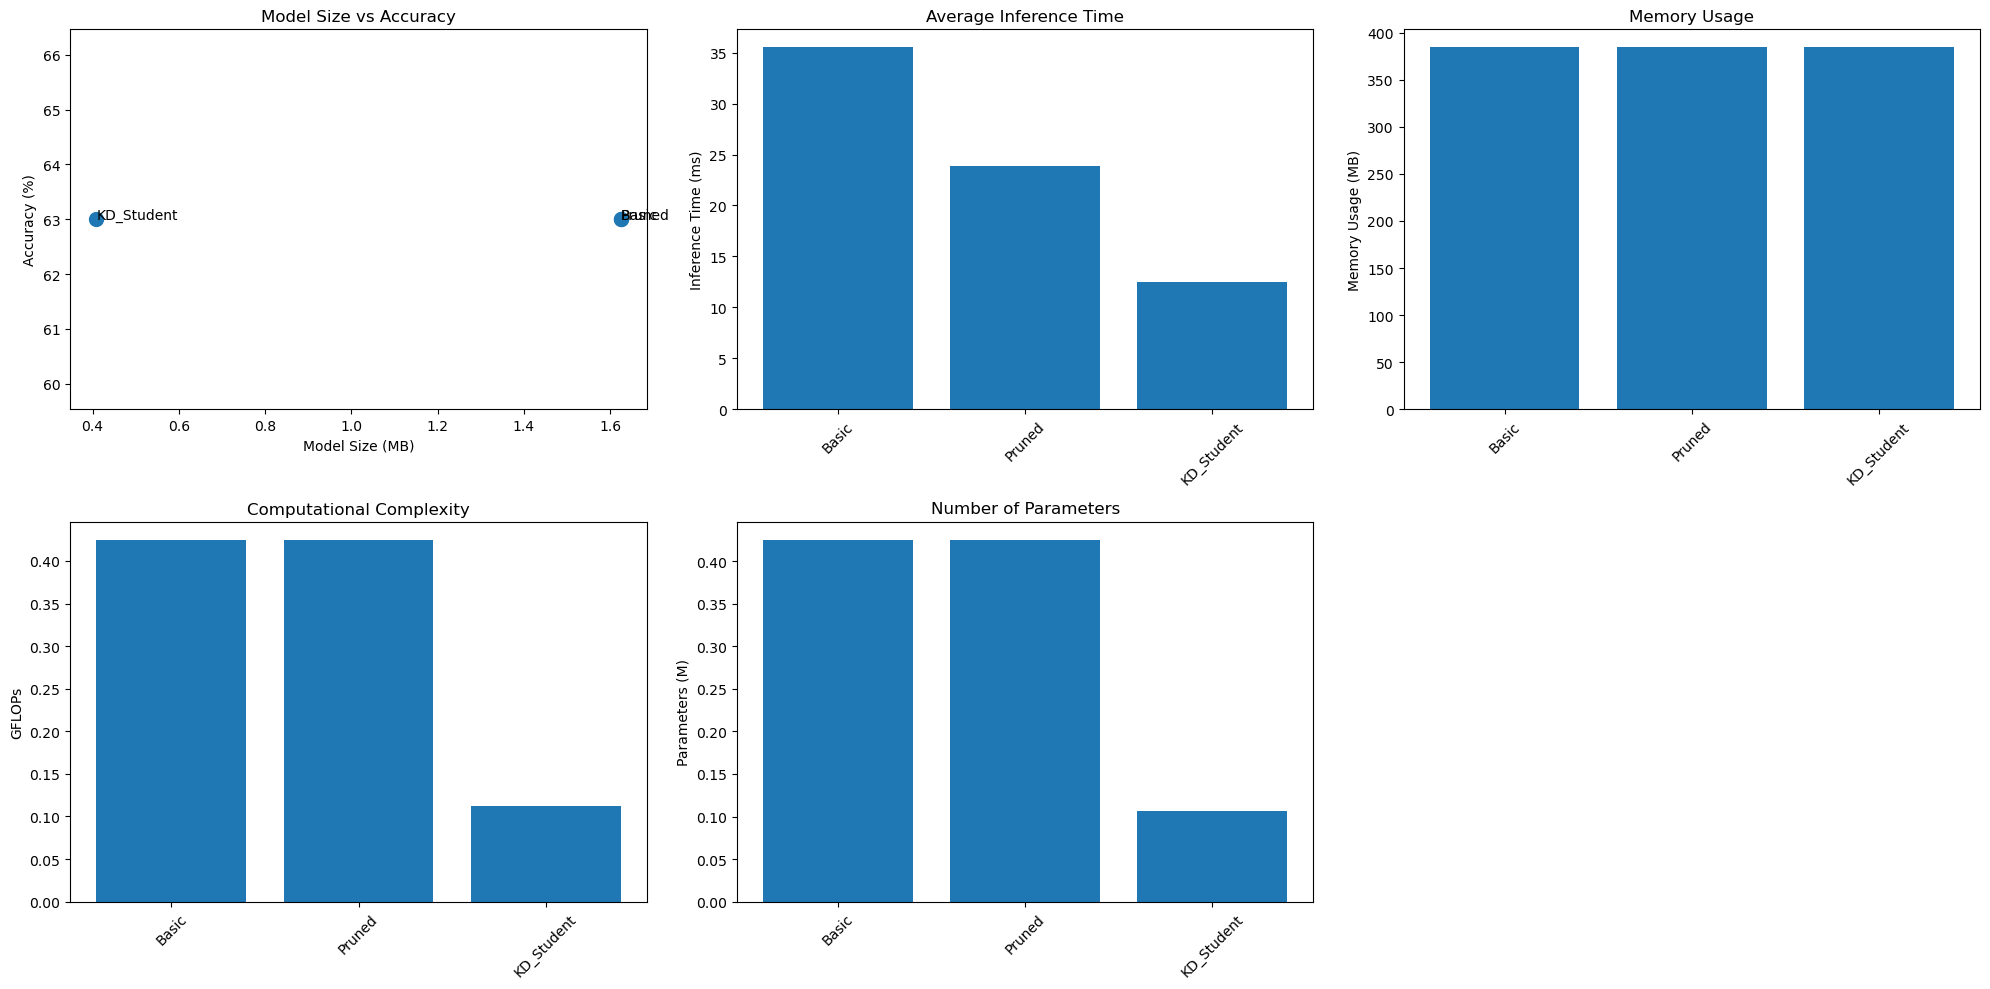

,Model,Parameters,Model_Size_MB,GFLOPs,Avg_Inference_Time_ms,Inference_Time_Std_ms,Memory_Usage_MB,Accuracy_%
0,Basic,424961,1.624403,0.424738,35.513320,22.028406,384.473437,63.0
1,Pruned,424961,1.624403,0.424738,23.823020,4.421144,384.480469,63.0
2,KD_Student,106369,0.409132,0.112588,12.493794,2.508870,384.486211,63.0


In [16]:
main()